In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

In [3]:


def read_llp_decay_results(
    summary_file: str, 
    hist_dir: Optional[str] = None
) -> Tuple[pd.DataFrame, Dict]:
    """
    读取LLP衰变结果文件
    
    参数:
        summary_file: 统计摘要文件路径 (llp_decay_summary.csv.gz)
        hist_dir: 直方图文件目录路径 (可选)
    
    返回:
        summary_df: 统计摘要DataFrame
        hist_data: 直方图数据字典
    """
    
    # 读取统计摘要
    if summary_file.endswith('.gz'):
        summary_df = pd.read_csv(summary_file, compression='gzip')
    else:
        summary_df = pd.read_csv(summary_file)
    
    print(f"成功读取 {len(summary_df)} 个LLP参数集")
    
    # 检查是否包含vis_br列
    if 'vis_br' not in summary_df.columns and 'Br_visible' in summary_df.columns:
        summary_df['vis_br'] = summary_df['Br_visible']
    elif 'vis_br' not in summary_df.columns:
        print("警告: 未找到vis_br或Br_visible列")
    
    # 读取直方图数据（如果提供了目录）
    hist_data = {}
    if hist_dir and os.path.exists(hist_dir):
        for filename in os.listdir(hist_dir):
            if filename.endswith('_hist.json'):
                file_path = os.path.join(hist_dir, filename)
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    # 从文件名提取参数
                    parts = filename.replace('_hist.json', '').split('_')
                    mass_str = parts[1].replace('em', 'e-').replace('m', '').replace('p', '.')
                    tau_str = parts[2].replace('em', 'e-').replace('t', '').replace('p', '.')
                    # print(mass_str, tau_str)
                    mass = float(mass_str)
                    lifetime = float(tau_str)
                    # print(mass, lifetime)
                    # 查找对应的tanb和vis_br
                    mask = (np.isclose(summary_df['mass'], mass) & 
                           np.isclose(summary_df['lifetime'], lifetime))
                    if mask.any():
                        tanb = summary_df.loc[mask, 'tanb'].iloc[0]
                        vis_br = summary_df.loc[mask, 'vis_br'].iloc[0] if 'vis_br' in summary_df.columns else 0.0
                        key = (mass, lifetime, tanb, vis_br)
                        hist_data[key] = data
                    
                except Exception as e:
                    print(f"读取直方图文件 {filename} 时出错: {e}")
    
    print(f"成功读取 {len(hist_data)} 个直方图文件")
    
    return summary_df, hist_data

def calculate_region_fraction_from_hist(
    hist_data: Dict,
    region_bounds: Dict[str, Tuple[float, float]]
) -> Dict:
    """
    从直方图数据计算区域内衰变比例
    
    参数:
        hist_data: 直方图数据字典
        region_bounds: 区域边界 {'x': (min, max), 'y': (min, max), 'z': (min, max)}
    
    返回:
        包含比例和计数的字典
    """
    results = {}
    
    for (mass, lifetime, tanb, vis_br), data in hist_data.items():
        try:
            # 获取统计信息
            stats = data.get('statistics', {})
            total_events = stats.get('total_weighted_events', 0)
            
            if total_events == 0:
                continue
            
            # 获取直方图数据
            histograms = data.get('histograms', {})
            
            # 计算各维度在区域内的比例
            fractions = {}
            counts_in_region = {}
            
            for axis in ['x', 'y', 'z']:
                if axis not in histograms or axis not in region_bounds:
                    continue
                
                # 获取直方图数据
                edges = np.array(histograms[axis]['bin_edges'])
                counts = np.array(histograms[axis]['counts'])
                
                # 找到区域内的分箱
                region_min, region_max = region_bounds[axis]
                bin_centers = (edges[:-1] + edges[1:]) / 2
                in_region_mask = (bin_centers >= region_min) & (bin_centers <= region_max)
                
                # 计算区域内计数和比例
                count_in_axis = np.sum(counts[in_region_mask])
                fraction_in_axis = count_in_axis / np.sum(counts) if np.sum(counts) > 0 else 0
                
                fractions[axis] = fraction_in_axis
                counts_in_region[axis] = count_in_axis
            
            # 计算三维区域比例（假设各维度独立）
            if len(fractions) == 3:
                fraction_3d = fractions['x'] * fractions['y'] * fractions['z']
                estimated_count = fraction_3d * total_events
            else:
                fraction_3d = 0
                estimated_count = 0
            
            # 保存结果
            results[(mass, lifetime, tanb, vis_br)] = {
                'mass': mass,
                'lifetime': lifetime,
                'tanb': tanb,
                'vis_br': vis_br,
                'total_events': total_events,
                'count_in_region': estimated_count,
                'fraction_in_region': fraction_3d,
                'fractions_by_axis': fractions,
                'counts_by_axis': counts_in_region
            }
            
        except Exception as e:
            print(f"计算LLP(m={mass}, τ={lifetime}, tanβ={tanb})时出错: {e}")
    
    return results

def calculate_region_fraction_from_stats(
    summary_df: pd.DataFrame,
    region_bounds: Dict[str, Tuple[float, float]],
    method: str = 'gaussian'
) -> pd.DataFrame:
    """
    从统计信息计算区域内衰变比例
    
    参数:
        summary_df: 统计摘要DataFrame
        region_bounds: 区域边界 {'x': (min, max), 'y': (min, max), 'z': (min, max)}
        method: 计算方法 ('gaussian' 或 'uniform')
    
    返回:
        包含比例和计数的DataFrame
    """
    results = []
    
    for idx, row in summary_df.iterrows():
        try:
            mass = row['mass']
            lifetime = row['lifetime']
            tanb = row['tanb']
            vis_br = row.get('vis_br', row.get('Br_visible', 0.0))
            total_events = row.get('total_weighted_events', 0)
            
            if total_events == 0:
                continue
            
            # 获取均值和标准差
            mean_x = row.get('mean_position_x', 0)
            mean_y = row.get('mean_position_y', 0)
            mean_z = row.get('mean_position_z', 0)
            
            std_x = row.get('std_position_x', 1)
            std_y = row.get('std_position_y', 1)
            std_z = row.get('std_position_z', 1)
            
            # 根据方法计算比例
            if method == 'gaussian':
                from scipy.stats import norm
                
                # 计算各维度在区域内的概率（假设正态分布）
                prob_x = norm.cdf(region_bounds['x'][1], mean_x, std_x) - norm.cdf(region_bounds['x'][0], mean_x, std_x)
                prob_y = norm.cdf(region_bounds['y'][1], mean_y, std_y) - norm.cdf(region_bounds['y'][0], mean_y, std_y)
                prob_z = norm.cdf(region_bounds['z'][1], mean_z, std_z) - norm.cdf(region_bounds['z'][0], mean_z, std_z)
                
                # 三维概率（假设独立）
                fraction = prob_x * prob_y * prob_z
                
            elif method == 'uniform':
                # 获取位置范围
                min_x = row.get('min_position_x', -1000)
                max_x = row.get('max_position_x', 1000)
                min_y = row.get('min_position_y', -1000)
                max_y = row.get('max_position_y', 1000)
                min_z = row.get('min_position_z', -1000)
                max_z = row.get('max_position_z', 1000)
                
                # 计算区域与总范围的重叠比例（假设均匀分布）
                overlap_x = max(0, min(region_bounds['x'][1], max_x) - max(region_bounds['x'][0], min_x))
                overlap_y = max(0, min(region_bounds['y'][1], max_y) - max(region_bounds['y'][0], min_y))
                overlap_z = max(0, min(region_bounds['z'][1], max_z) - max(region_bounds['z'][0], min_z))
                
                total_range_x = max_x - min_x
                total_range_y = max_y - min_y
                total_range_z = max_z - min_z
                
                if total_range_x > 0 and total_range_y > 0 and total_range_z > 0:
                    fraction_x = overlap_x / total_range_x
                    fraction_y = overlap_y / total_range_y
                    fraction_z = overlap_z / total_range_z
                    fraction = fraction_x * fraction_y * fraction_z
                else:
                    fraction = 0
            else:
                fraction = 0
            
            # 确保比例在合理范围内
            fraction = max(0, min(1, fraction))
            count_in_region = fraction * total_events
            
            # 保存结果
            results.append({
                'mass': mass,
                'lifetime': lifetime,
                'tanb': tanb,
                'vis_br': vis_br,
                'total_events': total_events,
                'count_in_region': count_in_region,
                'fraction_in_region': fraction,
                'mean_x': mean_x,
                'mean_y': mean_y,
                'mean_z': mean_z,
                'std_x': std_x,
                'std_y': std_y,
                'std_z': std_z,
                'method': method
            })
            
        except Exception as e:
            print(f"计算第{idx}行时出错: {e}")
    
    return pd.DataFrame(results)

def analyze_llp_decay_in_region(
    summary_file: str,
    region_bounds: Dict[str, Tuple[float, float]],
    hist_dir: Optional[str] = None,
    output_file: Optional[str] = None,
    method: str = 'auto'
) -> pd.DataFrame:
    """
    分析LLP在设定区域内的衰变比例
    
    参数:
        summary_file: 统计摘要文件路径
        region_bounds: 区域边界 {'x': (min, max), 'y': (min, max), 'z': (min, max)}
        hist_dir: 直方图文件目录路径 (可选)
        output_file: 输出文件路径 (可选)
        method: 计算方法 ('auto', 'hist', 'gaussian', 'uniform')
    
    返回:
        包含分析结果的DataFrame
    """
    
    print("=" * 60)
    print("LLP衰变区域分析")
    print("=" * 60)
    print(f"区域边界: X={region_bounds['x']}, Y={region_bounds['y']}, Z={region_bounds['z']}")
    
    # 读取数据
    summary_df, hist_data = read_llp_decay_results(summary_file, hist_dir)
    
    # 根据选择的方法进行计算
    if method == 'auto':
        # 自动选择方法：如果有直方图数据，使用直方图方法；否则使用高斯方法
        if hist_data and len(hist_data) > 0:
            method = 'hist'
        else:
            method = 'gaussian'
    
    print(f"使用计算方法: {method}")
    
    if method == 'hist' and hist_data:
        # 使用直方图数据计算
        results_dict = calculate_region_fraction_from_hist(hist_data, region_bounds)
        
        # 转换为DataFrame
        results = []
        for (mass, lifetime, tanb, vis_br), data in results_dict.items():
            results.append({
                'mass': data['mass'],
                'lifetime': data['lifetime'],
                'tanb': data['tanb'],
                'vis_br': data['vis_br'],
                'total_events': data['total_events'],
                'count_in_region': data['count_in_region'],
                'fraction_in_region': data['fraction_in_region'],
                'fraction_x': data['fractions_by_axis'].get('x', 0),
                'fraction_y': data['fractions_by_axis'].get('y', 0),
                'fraction_z': data['fractions_by_axis'].get('z', 0),
                'method': 'histogram'
            })
        
        results_df = pd.DataFrame(results)
        
    else:
        # 使用统计信息计算
        results_df = calculate_region_fraction_from_stats(
            summary_df, region_bounds, 
            method=method if method in ['gaussian', 'uniform'] else 'gaussian'
        )
    
    # 计算总结统计
    total_events_all = results_df['total_events'].sum()
    total_in_region_all = results_df['count_in_region'].sum()
    overall_fraction = total_in_region_all / total_events_all if total_events_all > 0 else 0
    
    print("\n分析结果总结:")
    print(f"总LLP参数集数量: {len(results_df)}")
    print(f"总衰变事件数: {total_events_all:.0f}")
    print(f"区域内总衰变事件数: {total_in_region_all:.0f}")
    print(f"总体比例: {overall_fraction:.6f} ({overall_fraction*100:.4f}%)")
    
    # 按质量分组统计
    if len(results_df) > 0:
        print("\n按质量分组的比例统计:")
        mass_groups = results_df.groupby(pd.cut(results_df['mass'], bins=5))
        for name, group in mass_groups:
            if len(group) > 0:
                group_frac = group['count_in_region'].sum() / group['total_events'].sum()
                print(f"  {name}: {len(group)}个参数, 平均比例={group_frac:.6f}")
    
    # 保存结果
    if output_file:
        results_df.to_csv(output_file, index=False, float_format='%.6e')
        print(f"\n结果已保存到: {output_file}")
    
    return results_df

def plot_region_fraction_analysis(
    results_df: pd.DataFrame,
    region_name: str = "设定区域",
    output_dir: str = "region_analysis_plots"
):
    """
    绘制区域分析结果
    
    参数:
        results_df: 分析结果DataFrame
        region_name: 区域名称
        output_dir: 输出目录
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 设置图形风格
    # plt.style.use('seaborn-v0_8-darkgrid')
    
    # 1. 比例随质量变化
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 比例 vs 质量
    ax = axes[0, 0]
    sc = ax.scatter(results_df['mass'], results_df['fraction_in_region'], 
                   c=results_df['tanb'], cmap='viridis', alpha=0.7, s=50)
    ax.set_xlabel('LLP Mass (GeV)', fontsize=12)
    ax.set_ylabel(f'Fraction in {region_name}', fontsize=12)
    ax.set_title(f'Decay Fraction vs Mass', fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('tanβ', fontsize=12)
    
    # 比例 vs tanβ
    ax = axes[0, 1]
    sc = ax.scatter(results_df['tanb'], results_df['fraction_in_region'], 
                   c=results_df['mass'], cmap='plasma', alpha=0.7, s=50)
    ax.set_xlabel('tanβ', fontsize=12)
    ax.set_ylabel(f'Fraction in {region_name}', fontsize=12)
    ax.set_title(f'Decay Fraction vs tanβ', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Mass (GeV)', fontsize=12)
    
    # 比例 vs vis_br
    ax = axes[0, 2]
    if 'vis_br' in results_df.columns:
        sc = ax.scatter(results_df['vis_br'], results_df['fraction_in_region'], 
                       c=results_df['mass'], cmap='coolwarm', alpha=0.7, s=50)
        ax.set_xlabel('Visible Branching Ratio', fontsize=12)
        ax.set_ylabel(f'Fraction in {region_name}', fontsize=12)
        ax.set_title(f'Decay Fraction vs Visible BR', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label('Mass (GeV)', fontsize=12)
    else:
        ax.text(0.5, 0.5, 'No vis_br data', ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('Visible BR Not Available', fontsize=14)
    
    # 区域事件数分布
    ax = axes[1, 0]
    ax.hist(results_df['count_in_region'], bins=30, alpha=0.7, color='green', edgecolor='black')
    ax.set_xlabel('Count in Region', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Counts in Region', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # 比例分布
    ax = axes[1, 1]
    ax.hist(results_df['fraction_in_region'], bins=30, alpha=0.7, color='red', edgecolor='black')
    ax.set_xlabel('Fraction in Region', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Fractions', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # vis_br分布
    ax = axes[1, 2]
    if 'vis_br' in results_df.columns:
        ax.hist(results_df['vis_br'], bins=30, alpha=0.7, color='purple', edgecolor='black')
        ax.set_xlabel('Visible Branching Ratio', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Distribution of Visible BR', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No vis_br data', ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('Visible BR Distribution Not Available', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{region_name}_fraction_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. 详细统计表格图
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # 选择前10个结果显示
    display_columns = ['mass', 'tanb', 'vis_br', 'total_events', 'count_in_region', 'fraction_in_region']
    available_columns = [col for col in display_columns if col in results_df.columns]
    
    display_df = results_df.nlargest(10, 'fraction_in_region')[available_columns]
    
    # 格式化显示
    display_df_formatted = display_df.copy()
    display_df_formatted['fraction_in_region'] = display_df_formatted['fraction_in_region'].apply(
        lambda x: f"{x:.2e} ({x*100:.4f}%)")
    display_df_formatted['tanb'] = display_df_formatted['tanb'].apply(lambda x: f"{x:.2e}")
    
    if 'vis_br' in display_df_formatted.columns:
        display_df_formatted['vis_br'] = display_df_formatted['vis_br'].apply(lambda x: f"{x:.2e}")
    
    # 创建表格
    table_data = [display_df_formatted.columns.tolist()] + display_df_formatted.values.tolist()
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    
    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # 设置标题行样式
    for i in range(len(display_df_formatted.columns)):
        cell = table[(0, i)]
        cell.set_facecolor('#40466e')
        cell.set_text_props(weight='bold', color='white')
    
    ax.set_title(f'Top 10 LLP Parameters with Highest Fraction in {region_name}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{region_name}_top_results.png'), dpi=150, bbox_inches='tight')
    plt.show()



LLP衰变区域分析
区域边界: X=(26000, 36000), Y=(-7000, 3000), Z=(5000, 15000)
成功读取 861 个LLP参数集
成功读取 861 个直方图文件
使用计算方法: hist

分析结果总结:
总LLP参数集数量: 861
总衰变事件数: 1490057651
区域内总衰变事件数: 53817
总体比例: 0.000036 (0.0036%)

按质量分组的比例统计:
  (0.0991, 0.28]: 369个参数, 平均比例=0.000033
  (0.28, 0.46]: 205个参数, 平均比例=0.000017
  (0.46, 0.64]: 123个参数, 平均比例=0.000054
  (0.64, 0.82]: 82个参数, 平均比例=0.000056
  (0.82, 1.0]: 82个参数, 平均比例=0.000050

结果已保存到: /media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/region_analysis_results_CODEXb.csv

前10个结果:
          mass         tanb       vis_br  total_events  count_in_region  \
0 2.818380e-01 1.995260e+04 3.715200e-14  1.730612e+06     0.000000e+00   
1 2.818380e-01 3.981070e+03 2.344040e-11  1.730612e+06     0.000000e+00   
2 8.912510e-01 6.309570e+04 9.835740e-16  1.730616e+06     0.000000e+00   
3 1.584890e-01 3.162280e+02 3.466040e-11  1.730611e+06     0.000000e+00   
4 4.466840e-01 1.584890e+01 1.472240e-01  1.730614e+06     0.000000e+00   


/tmp/ipykernel_492461/2826191045.py:331: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mass_groups = results_df.groupby(pd.cut(results_df['mass'], bins=5))


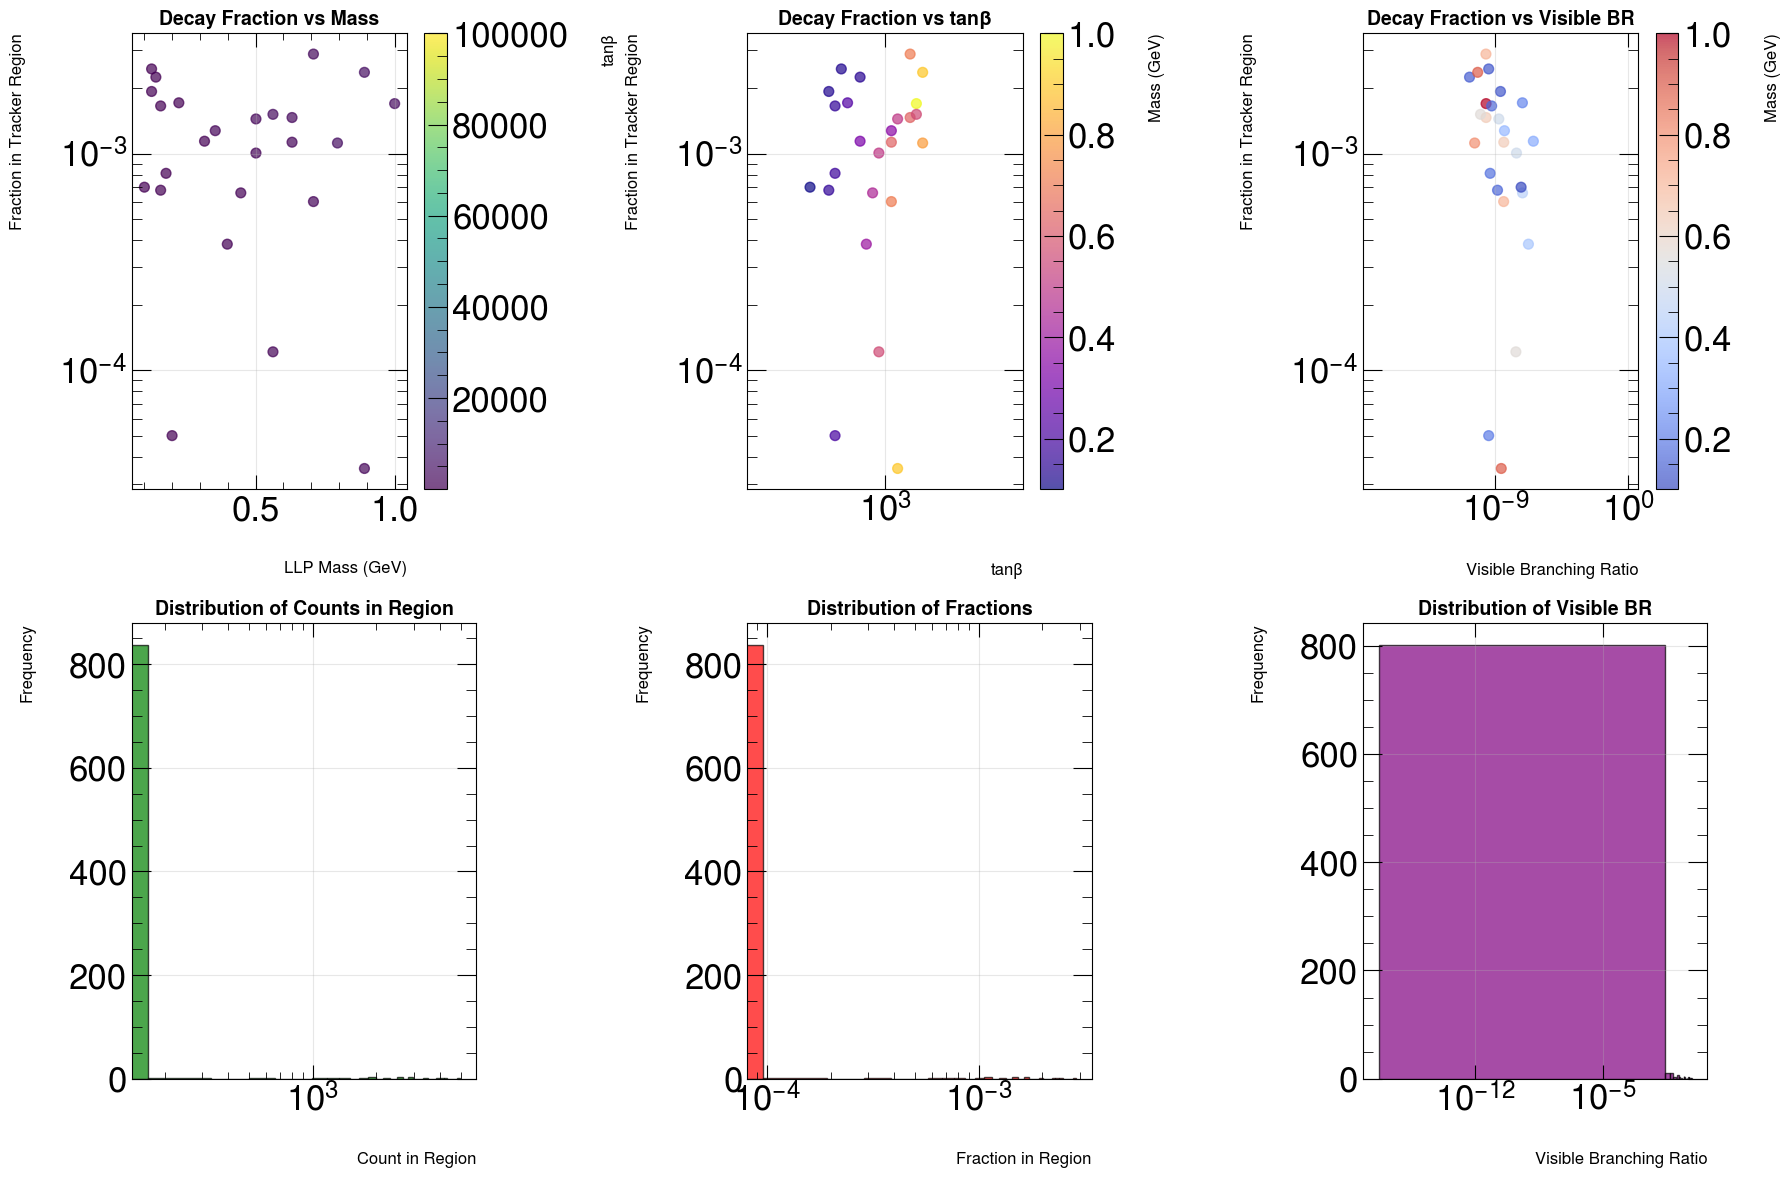

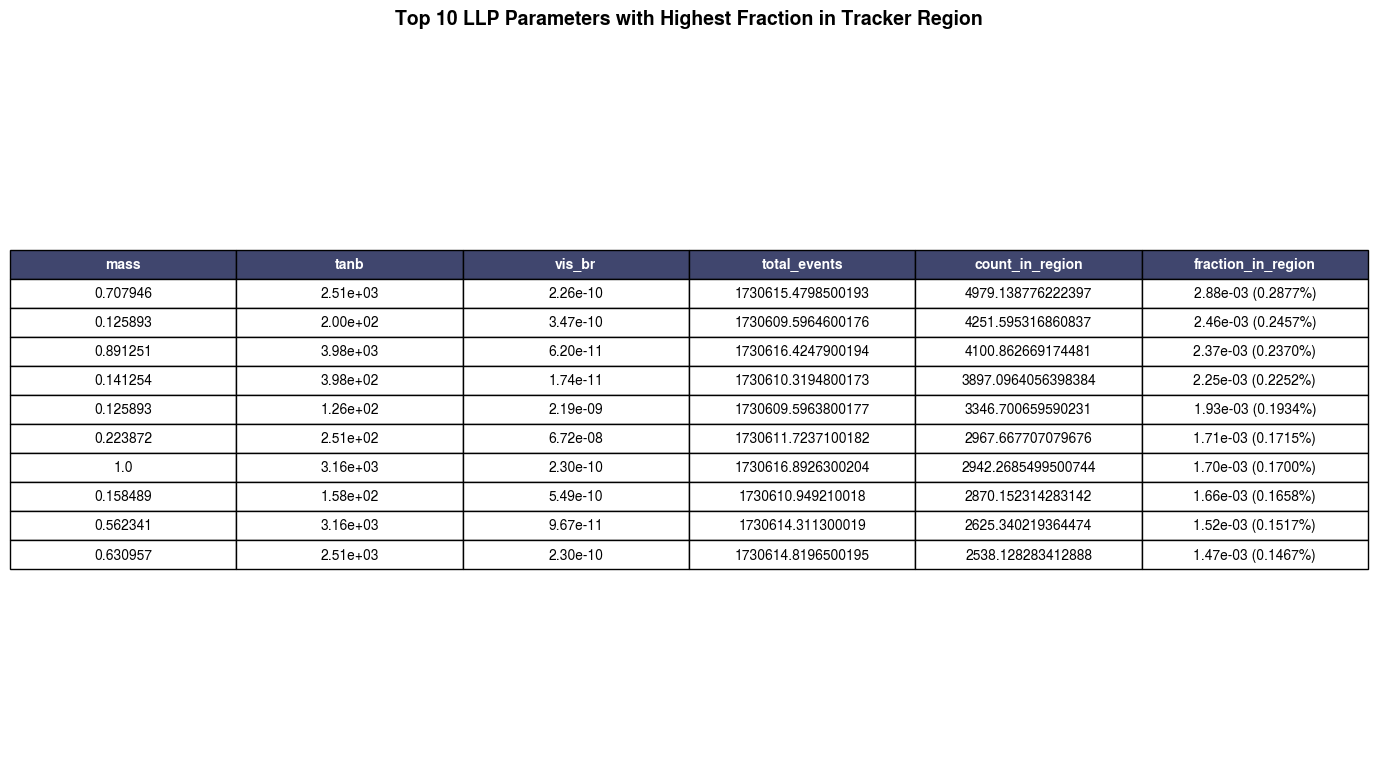

分析报告已生成: /media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/region_analysis_report_CODEX.txt


In [4]:
# 使用示例
if __name__ == "__main__":
    # 定义文件路径
    SUMMARY_FILE = "/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/LLP_DECAY/B_511_2HDMH_A/llp_decay_summary.csv.gz"
    HIST_DIR = "/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/LLP_DECAY/B_511_2HDMH_A"
    OUTPUT_FILE = "/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/region_analysis_results_CODEXb.csv"
    
    # 定义分析区域（示例：探测器内部区域）
    # 单位：mm
    REGION_BOUNDS = {
        'x': (26000, 36000),    # 跟踪器区域 X方向
        'y': (-7000, 3000),    # 跟踪器区域 Y方向
        'z': (5000, 15000)     # 跟踪器区域 Z方向
    }
    
    # 执行分析
    results_df = analyze_llp_decay_in_region(
        summary_file=SUMMARY_FILE,
        region_bounds=REGION_BOUNDS,
        hist_dir=HIST_DIR,
        output_file=OUTPUT_FILE,
        method='auto'  # 自动选择最佳方法
    )
    
    # 显示前10个结果
    print("\n前10个结果:")
    pd.set_option('display.float_format', lambda x: f'{x:.6e}')
    columns_to_show = ['mass', 'tanb', 'vis_br', 'total_events', 'count_in_region', 'fraction_in_region']
    available_columns = [col for col in columns_to_show if col in results_df.columns]
    print(results_df[available_columns].head(10))
    
    # 绘制分析结果
    plot_region_fraction_analysis(
        results_df, 
        region_name="Tracker Region",
        output_dir="/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/plots"
    )
    
    # 生成总结报告
    def generate_summary_report(results_df, region_bounds, output_file):
        """生成分析总结报告"""
        
        with open(output_file, 'w') as f:
            f.write("LLP衰变区域分析报告\n")
            f.write("=" * 60 + "\n\n")
            
            f.write(f"分析区域: X={region_bounds['x']}, Y={region_bounds['y']}, Z={region_bounds['z']} mm\n")
            f.write(f"分析LLP参数集数量: {len(results_df)}\n")
            
            total_events = results_df['total_events'].sum()
            total_in_region = results_df['count_in_region'].sum()
            overall_fraction = total_in_region / total_events if total_events > 0 else 0
            
            f.write(f"总衰变事件数: {total_events:.0f}\n")
            f.write(f"区域内总衰变事件数: {total_in_region:.0f}\n")
            f.write(f"总体比例: {overall_fraction:.6f} ({overall_fraction*100:.4f}%)\n\n")
            
            # 找到比例最高和最低的LLP
            if len(results_df) > 0:
                max_idx = results_df['fraction_in_region'].idxmax()
                min_idx = results_df['fraction_in_region'].idxmin()
                
                f.write("比例最高的LLP:\n")
                f.write(f"  质量: {results_df.loc[max_idx, 'mass']} GeV\n")
                f.write(f"  tanβ: {results_df.loc[max_idx, 'tanb']}\n")
                f.write(f"  vis_br: {results_df.loc[max_idx, 'vis_br']}\n")
                f.write(f"  比例: {results_df.loc[max_idx, 'fraction_in_region']:.6f}\n\n")
                
                f.write("比例最低的LLP:\n")
                f.write(f"  质量: {results_df.loc[min_idx, 'mass']} GeV\n")
                f.write(f"  tanβ: {results_df.loc[min_idx, 'tanb']}\n")
                f.write(f"  vis_br: {results_df.loc[min_idx, 'vis_br']}\n")
                f.write(f"  比例: {results_df.loc[min_idx, 'fraction_in_region']:.6f}\n")
            
            # 按vis_br分组统计
            if 'vis_br' in results_df.columns and len(results_df) > 0:
                f.write("\n按vis_br分组统计:\n")
                results_df['vis_br_category'] = pd.cut(results_df['vis_br'], 
                                                      bins=[0, 1e-6, 1e-4, 1e-2, 1],
                                                      labels=['<1e-6', '1e-6-1e-4', '1e-4-1e-2', '>1e-2'])
                
                for category in results_df['vis_br_category'].unique():
                    if pd.notna(category):
                        category_df = results_df[results_df['vis_br_category'] == category]
                        category_frac = category_df['count_in_region'].sum() / category_df['total_events'].sum() if category_df['total_events'].sum() > 0 else 0
                        f.write(f"  {category}: {len(category_df)}个参数, 平均比例={category_frac:.6f}\n")
        
        print(f"分析报告已生成: {output_file}")
    
    # 生成报告
    generate_summary_report(
        results_df, 
        REGION_BOUNDS,
        "/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/region_analysis_report_CODEX.txt"
    )

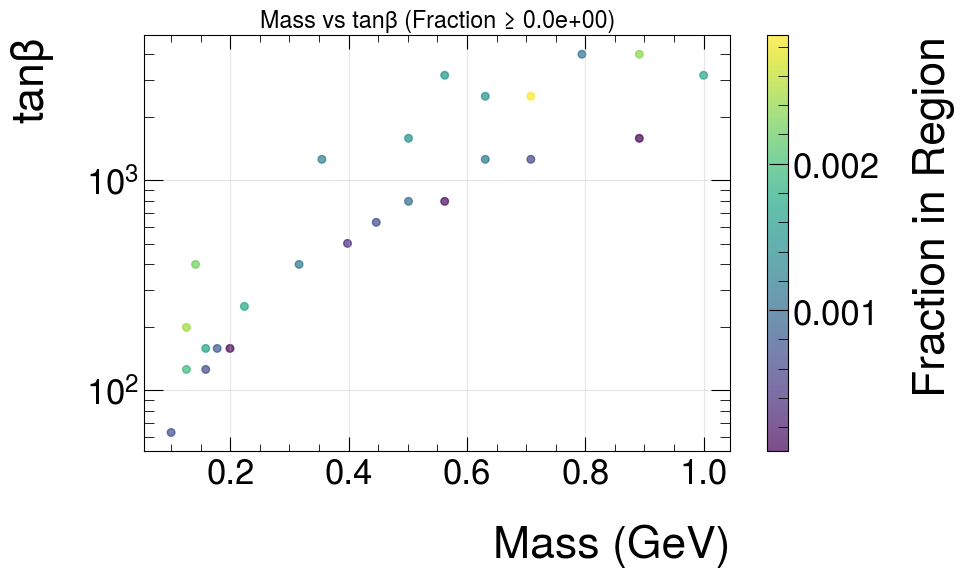

,mass,lifetime,tanb,vis_br,total_events,count_in_region,fraction_in_region,fraction_x,fraction_y,fraction_z,method
16,1.995260e-01,1.265850e+05,1.584890e+02,3.466240e-10,1.730612e+06,8.660943e+01,5.004556e-05,5.949300e-04,5.708305e-01,1.473644e-01,histogram
70,6.309570e-01,2.525620e+05,1.258930e+03,3.652680e-09,1.730615e+06,1.952982e+03,1.128490e-03,1.401548e-02,4.451634e-01,1.808716e-01,histogram
84,6.309570e-01,1.005470e+06,2.511890e+03,2.304680e-10,1.730615e+06,2.538128e+03,1.466605e-03,3.855545e-02,1.892625e-01,2.009846e-01,histogram
126,1.000000e+00,4.002790e+05,3.162280e+03,2.303910e-10,1.730617e+06,2.942269e+03,1.700127e-03,2.758773e-02,3.531925e-01,1.744833e-01,histogram
193,5.011870e-01,7.986720e+05,1.584890e+03,1.685750e-09,1.730614e+06,2.499917e+03,1.444526e-03,4.678018e-02,1.459522e-01,2.115695e-01,histogram
286,7.079460e-01,1.788000e+05,1.258930e+03,3.584580e-09,1.730615e+06,1.039588e+03,6.007041e-04,6.406304e-03,5.307911e-01,1.766564e-01,histogram
291,3.981070e-01,1.593570e+05,5.011870e+02,1.722250e-07,1.730614e+06,6.614717e+02,3.822180e-04,4.481054e-03,5.618275e-01,1.518197e-01,histogram
303,1.584890e-01,2.525700e+05,1.584890e+02,5.493490e-10,1.730611e+06,2.870152e+03,1.658462e-03,1.739820e-02,4.213504e-01,2.262339e-01,histogram
305,1.258930e-01,3.179710e+05,1.258930e+02,2.186980e-09,1.730610e+06,3.346701e+03,1.933828e-03,2.422961e-02,3.398712e-01,2.348319e-01,histogram
331,7.079460e-01,7.118140e+05,2.511890e+03,2.261710e-10,1.730615e+06,4.979139e+03,2.877091e-03,5.033365e-02,2.863637e-01,1.996077e-01,histogram


In [5]:
import mplhep as hep
hep.style.use(hep.style.ALICE)
def simple_mass_tanb_scatter(analysis_file, min_fraction=1e-6):
    """
    最简单的质量 vs tanβ散点图
    """
    
    # 读取数据
    df = pd.read_csv(analysis_file, compression='gzip' if analysis_file.endswith('.gz') else None)
    
    # 筛选数据
    mask = df['fraction_in_region'] > min_fraction
    filtered_df = df[mask]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制散点图
    plt.scatter(
        filtered_df['mass'],
        filtered_df['tanb'],
        c=filtered_df['fraction_in_region'],
        cmap='viridis',
        s=30,
        alpha=0.7
    )
    
    # 设置坐标轴
    plt.xlabel('Mass (GeV)')
    plt.ylabel('tanβ')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # 添加颜色条
    plt.colorbar(label='Fraction in Region')
    
    # 标题
    plt.title(f'Mass vs tanβ (Fraction ≥ {min_fraction:.1e})')
    
    plt.tight_layout()
    plt.show()
    
    return filtered_df

# 使用最简单版本
simple_mass_tanb_scatter('/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Files/LLP_DATA/Block/Test/Analyse/CODEX-b_511/region_analysis_results_CODEXb.csv', min_fraction=0)